## Linear Regression

$$ y = w_0x_0 + w_1x_1 + ... + w_mx_m = \sum_{j=0}^{m} w^Tx$$

### Closed form solution
$$ w= (X^TX)^-1X^Ty $$

#### Import dependencies

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

#### Random data for toy problem

In [2]:
a= np.random.normal(0,1,2000).reshape(2000,1)
b = np.ones((2000,2))

for i in range(2000):
    b[i][0] = a[i]
    b[i][1] = a[i]*2  + np.random.normal()


In [3]:
df = pandas.DataFrame(b, columns = ['X','Y'])
df

,X,Y
0,0.863815,1.013930
1,-0.177209,-0.880755
2,1.951065,2.401838
3,-0.055535,-1.084298
4,0.735910,0.419253
...,...,...
1995,0.207282,-0.423281
1996,-0.711794,0.147316
1997,1.816471,3.091297
1998,-0.343864,-0.036103


#### Normalize X data

In [4]:
yield_column = df.loc[:, df.columns == 'Y'] 
del df['Y']
normalized_df = (df-df.mean())/df.std()
normalized_df = pandas.merge(normalized_df, yield_column, left_index=True, right_index=True)
normalized_df

,X,Y
0,0.903767,1.013930
1,-0.152461,-0.880755
2,2.006896,2.401838
3,-0.029009,-1.084298
4,0.773994,0.419253
...,...,...
1995,0.237646,-0.423281
1996,-0.694853,0.147316
1997,1.870336,3.091297
1998,-0.321550,-0.036103


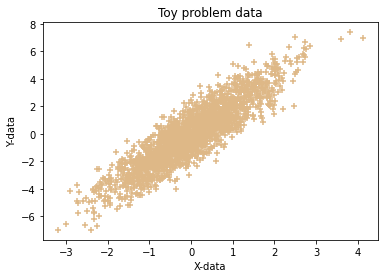

In [5]:
plt.scatter('X','Y',data =normalized_df, marker = '+', color = 'burlywood')
plt.ylabel('Y-data')
plt.xlabel('X-data')
plt.title('Toy problem data')
plt.show()

In [6]:
def mse(y_pred,y_test):
    '''Returns the mean squared error given two numpy arrays'''
    sum_squared_error = np.sum(np.square(y_test - y_pred))
    m_s_e = sum_squared_error/len(y_pred)
    return m_s_e


def linear_regression_fit(x_train,y_train):
    '''Returns the closed from w parameter given the x and y data'''
    
    x_dash_train = np.transpose(x_train)
    w = np.linalg.inv(x_dash_train @ x_train) @ x_dash_train @ y_train 
    return w

def linear_regression_predict(x_test,w_star):
    '''Returns the predictions given some test data and wstar'''
    y_pred=  x_test @ w_star
    
    return y_pred


In [7]:
# Split the data into 60%-40% for train/test
split = int(len(df)*0.6)
data = np.array(normalized_df)
np.random.seed(0)
shuffle = np.random.permutation(len(data))


In [8]:
x_linear= np.ones((len(data),1))
y_linear= np.ones((len(data),1))

for i in range(len(data)):
    x_linear[i] = data[i][0]
    y_linear[i] = data[i][-1]
    
x_linear = x_linear[shuffle]
y_linear = y_linear[shuffle]
x_train_linear= x_linear[:split]
y_train_linear = y_linear[:split]

x_test_linear = x_linear[split:]
y_test_linear = y_linear[split:]

In [9]:
w_star = linear_regression_fit(x_train_linear,y_train_linear)
y_pred_linear = linear_regression_predict(x_test_linear,w_star)
print("The mean squared error for the Linear Regression toy problem is {}".format(mse(y_pred_linear,y_test_linear)))

The mean squared error for the Linear Regression toy problem is 1.0818906625257778


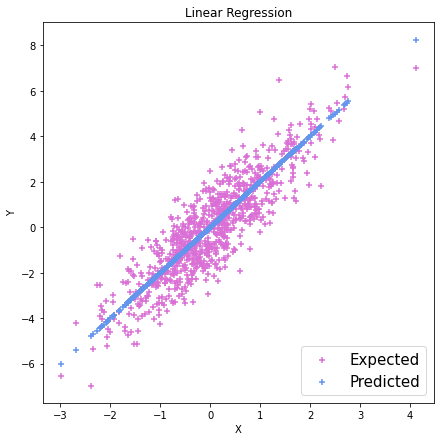

In [10]:
plt.figure(figsize=(7,7))
plt.scatter(x_test_linear,y_test_linear,color = 'orchid',marker = '+')
plt.scatter(x_test_linear,y_pred_linear,color = 'cornflowerblue',marker = '+')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression')
plt.legend(["Expected", "Predicted"], loc ="lower right",prop={'size': 15} )
plt.show()

### Gaussian Process

In [11]:
x_gaussian = normalized_df.iloc[:,:-1].to_numpy()
y_gaussian = normalized_df.iloc[:,-1].to_numpy()

x_gaussian = x_gaussian[shuffle]
y_gaussian = y_gaussian[shuffle]

x_train_gaussian= x_gaussian[:split]
y_train_gaussian = y_gaussian[:split]

x_test_gaussian = x_gaussian[split:]
y_test_gaussian = y_gaussian[split:]


y_pred_linear_gaussian = linear_regression_predict(x_train_linear,w_star)

In [12]:
def kernel_func(x1,x2,s,l):
    euclidean_distance = -2 * x1 @ x2.T + np.sum(x1**2,axis=1).reshape(x1.shape[0],1) + np.sum(x2**2,axis=1)
    kernel = s * np.exp(-euclidean_distance / l)
    return kernel

def euclidean_distance(x1,x2):
    
    euclidean_distance = -2 * x1 @ x2.T + np.sum(x1**2,axis=1).reshape(x1.shape[0],1) + np.sum(x2**2,axis=1)
    return euclidean_distance

In [13]:
def optimize_GP(xtrain,ytrain,a=0.001,num_iter=100):
    
    np.random.seed(0)
    n= len(xtrain)
    log_s, log_l ,log_sigma = np.random.normal(), np.random.normal(), np.random.normal()
    grad_s ,grad_l, grad_sigma = np.zeros(3,dtype=int)
    
    cost_function = np.zeros(num_iter)
    

    ytrain = ytrain.reshape(len(ytrain),1)
    ytrain = (ytrain - y_pred_linear_gaussian)
    
    sd = np.std(ytrain)
    ytrain = ytrain / sd
    
    identity_mat = np.eye(xtrain.shape[0])
    
    # Implementing gradient descent
    for i in range(num_iter):
        
        kernel = kernel_func(xtrain,xtrain,np.exp(log_s),np.exp(log_l))
        R = kernel + np.exp(log_sigma) * identity_mat
        
        L = np.linalg.cholesky(R)
        R_inv = linalg.cho_solve((L,True), identity_mat)
        
        term_sigma = np.exp(log_sigma) * identity_mat
        grad_sigma = -0.5 * np.trace(R_inv @ term_sigma) + 0.5 * np.trace(ytrain.reshape(1,-1) @ R_inv @ term_sigma @ R_inv @ ytrain.reshape(-1,1))# - sigma / 2
        
        grad_s = -0.5 * np.trace(R_inv @ kernel) + 0.5 * np.trace(ytrain.reshape(1,-1) @ R_inv @ kernel @ R_inv @ ytrain.reshape(-1,1))# - s /2 
        
        term_l = euclidean_distance(xtrain,xtrain) / np.exp(log_l) * kernel
        grad_l = -0.5 * np.trace(R_inv @ term_l) + 0.5 * np.trace(ytrain.reshape(1,-1) @ R_inv @ term_l @ R_inv @ ytrain.reshape(-1,1))# - l / 2
        cost_function[i] = -(n/2) * np.log(2 * np.pi) - 0.5 * np.prod(np.linalg.slogdet(R)) - 0.5 * np.trace(ytrain.reshape(1,-1) @ R_inv @ ytrain.reshape(-1,1))
        print("iteration {}".format(i))
        print('l :{}  s:{} sigma:{}  cost:{}'.format(np.exp(log_l), np.exp(log_s), np.exp(log_sigma), cost_function[i]))
        
        if np.isclose(cost_function[i],cost_function[i-1]):
            print("Answer converged in {} iterations".format(i))
            return np.exp(log_l), np.exp(log_s), np.exp(log_sigma)
        
        log_s +=  a * grad_s
        log_l +=  a * grad_l
        log_sigma +=  a * grad_sigma
        
    return np.exp(log_l), np.exp(log_s), np.exp(log_sigma)
        

In [14]:
l,s,sigma = optimize_GP(x_train_gaussian,y_train_gaussian)

iteration 0
l :1.4920592434019648  s:5.836039190663969 sigma:2.661095776728801  cost:-1932.6632235509283
iteration 1
l :1.4999444543113039  s:5.810854136024948 sigma:1.8344683500642625  cost:-1811.8238789774307
iteration 2
l :1.5081474978583993  s:5.785324218896963 sigma:1.3986440444957877  cost:-1751.2746958504833
iteration 3
l :1.5164537682755774  s:5.759727924347811 sigma:1.1796601489182612  cost:-1728.7553666308
iteration 4
l :1.5247404123546222  s:5.734229994183008 sigma:1.0766118728207867  cost:-1722.5205939660045
iteration 5
l :1.5329756810461552  s:5.708902698381751 sigma:1.0310927787985866  cost:-1721.1283845037794
iteration 6
l :1.5411662466625802  s:5.683769845381666 sigma:1.0118513489153986  cost:-1720.828730763817
iteration 7
l :1.5493213295259403  s:5.658837606936621 sigma:1.0039101282336687  cost:-1720.737912824244
iteration 8
l :1.5574448975780755  s:5.634106805496803 sigma:1.0006700105928592  cost:-1720.6841879525618
iteration 9
l :1.5655372391015425  s:5.6095766087913

iteration 78
l :2.0022390649328066  s:4.285953209780252 sigma:0.9991090618466371  cost:-1718.6660693496383
iteration 79
l :2.007005583481866  s:4.270631893040968 sigma:0.9991228571808994  cost:-1718.64762483782
iteration 80
l :2.011742993574139  s:4.255389827944581 sigma:0.9991366795087646  cost:-1718.6293158033118
iteration 81
l :2.016451946557625  s:4.2402261572392215 sigma:0.9991505262033122  cost:-1718.6111386161544
iteration 82
l :2.0211330846449327  s:4.225140042134639 sigma:0.9991643947432775  cost:-1718.5930897614548
iteration 83
l :2.0257870408737952  s:4.210130661818782 sigma:0.9991782827098142  cost:-1718.575165835642
iteration 84
l :2.030414439085047  s:4.195197212984816 sigma:0.9991921877832967  cost:-1718.5573635428038
iteration 85
l :2.0350158939165985  s:4.180338909368717 sigma:0.9992061077401052  cost:-1718.5396796911352
iteration 86
l :2.0395920108120156  s:4.165554981297426 sigma:0.9992200404494533  cost:-1718.522111189498
iteration 87
l :2.0441433860424056  s:4.1508

In [15]:
def gaussian_process_fit(xtrain,ytrain,xtest,l,s,sigma):
    kstardot = kernel_func(xtest,xtrain,s,l)
    k = kernel_func(xtrain,xtrain,s,l)
    kstarstar = kernel_func(xtest,xtest,s,l)
    kdotstar = kernel_func(xtrain,xtest,s,l)
    a = np.linalg.inv(k + sigma* np.eye(len(k)))
    mu_star =  kstardot @ a @ytrain
    var_star = kstarstar - kstardot@ a @ kdotstar + sigma
    
    
    
    return mu_star,var_star

In [16]:
def gaussian_process_predict(mu_star,var_star):
    np.random.seed(0)
    y_pred = np.random.multivariate_normal(mu_star,var_star)
    
    return y_pred 

In [21]:
mu_star, var_star = gaussian_process_fit(x_train_gaussian,y_train_gaussian,x_test_gaussian,l,s,sigma)
y_pred_gaussian = gaussian_process_predict(mu_star,var_star)
print("The mean squared error for the Gaussian Process toy problem is {}".format(mse(y_pred_gaussian,y_test_gaussian)))

The mean squared error for the Gaussian Process toy problem is 4.042164187083633


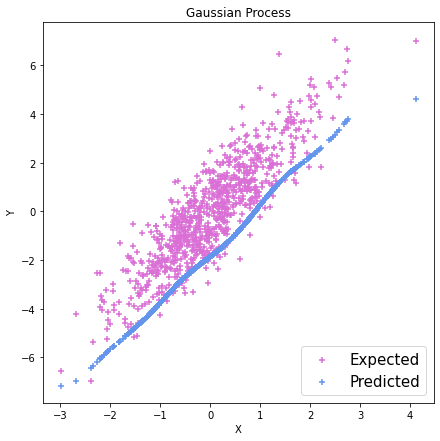

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(x_test_gaussian,y_test_gaussian,color = 'orchid',marker = '+')
plt.scatter(x_test_gaussian,y_pred_gaussian,color = 'cornflowerblue',marker = '+')
plt.title('Gaussian Process')
plt.xlabel('X')
plt.ylabel('Y')

plt.legend(["Expected", "Predicted"], loc ="lower right",prop={'size': 15} )